# MPS code

In [80]:
%matplotlib inline
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.linalg import svd
import matplotlib as mpl
import time
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rc('font',family='FreeSerif')
mpl.rc('xtick',labelsize=30)
mpl.rc('ytick',labelsize=30)

### Linestyles ###
colors={'red':(241/255.,88/255.,84/255.),\
        'orange':(250/255,164/255.,58/255.),\
        'pink':(241/255,124/255.,176/255.),\
        'brown':(178/255,145/255.,47/255.),\
        'purple':(178/255,118/255.,178/255.),\
        'green':(96/255,189/255.,104/255.),\
        'blue':(93/255,165/255.,218/255.),\
        'yellow':(222/255., 207/255., 63/255),\
        'black':(0.,0.,0.)}
collab = ['brown','green','blue','pink','black']
linewidth = [2,2,3,3,4]
linestyle = ['solid','dashed','dashdot','dotted','solid']

## 1. Hamiltonian in the rotating frame

The system Hamiltonian:

\begin{align}
\hat{H}_S=\hbar\Delta_c\hat{c}^\dagger\hat{c} + \hbar\Delta_e\hat{\sigma}_+\hat{\sigma}_-
            +\hbar g\left(\hat{c}^\dagger\hat{\sigma}_-+\hat{\sigma}_+\hat{c}\right)
            +\frac{\hbar\Omega_c}{2}\left(\hat{c}+\hat{c}^\dagger\right)
            +\frac{\hbar\Omega_e}{2}\left(\hat{\sigma}_-+\hat{\sigma}_+\right)
\end{align}

The interaction with the environment with feedback:

\begin{align}
\hat{H}_{fb}(t)=-i\hbar\left\{\left[\sqrt{\gamma_R}\hat{b}(t-\tau)e^{-i\phi}+\sqrt{\gamma_L}\hat{b}(t)\right]\hat{c}^\dagger-\left[\sqrt{\gamma_R}\hat{b}^\dagger(t-\tau)e^{i\phi}+\sqrt{\gamma_L}\hat{b}^\dagger(t)\right]\hat{c}\right\}
\end{align}

where the feedback phase is
\begin{align}
\phi=\pi-\omega_L\tau
\end{align}

The bath is originally Markovain with
\begin{align}
\left[\hat{b}(t),\hat{b}^\dagger(t^\prime)\right]=\delta(t-t^\prime)
\end{align}


## 2. Time-evolution

\begin{align}
|\Psi(t_{k+1})\rangle=U(t_{k+1},t_k)|\Psi(t_k)\rangle
\end{align}

with $\Psi$ written as a Matrix Product State. The time-evolution operator can be expanded as
\begin{align}
U(t_{k+1},t_k) &= \exp{\left[-\frac{i}{\hbar}\left(H_S\Delta t+\int_{t_k}^{t_{k+1}}H_{fb}(t)dt\right)\right]}\\
{\bf U}&=\exp{\left({\bf M}_S+{\bf M}_B\right)} = \sum_{n=0}^\infty\frac{1}{n!}\left({\bf M}_S+{\bf M}_B\right)^n
\end{align}
where $t_k=k\Delta t$ and $\Delta B(t_k) = \int_{t_k}^{t_{k+1}}b(t)dt$. This means that
\begin{align}
\left[\Delta B(t_k),\Delta B^\dagger(t_j)\right] = \Delta t \delta_{k,j}
\end{align}

Therefore the different orders of the expansion above are:
\begin{align}
{\bf U} &=\mathbb{1}+\color{red}{{\bf M}_B}+\color{orange}{{\bf M}_S+\frac{1}{2}{\bf M}_B^2}+
            \color{green}{\frac{1}{2}\left({\bf M}_S{\bf M}_B+{\bf M}_B{\bf M}_S\right)+\frac{1}{6}{\bf M}_B^3}+
            \color{blue}{\frac{1}{2}{\bf M}_S^2+\frac{1}{6}\left({\bf M}_S{\bf M}_B^2+{\bf M}_B{\bf M}_S{\bf M}_B+{\bf M}_B^2{\bf M}_S\right)+\frac{1}{24}{\bf M}_B^4}+\mathcal{O}(\Delta t^{5/2})
\end{align}
This means that to first order we have:
<img src='U_mat_JCM.png'>

## 3. Test case #1: no feedback
Let us consider a TLS on a waveguide. We need up to 4 photons in the environment and a system vector with size 2. $\gamma_R=0$
<img src='U_mat_TLS.png'>

initial excitation: 1
initial ground probability: 0
elapsed time: 00:20:01


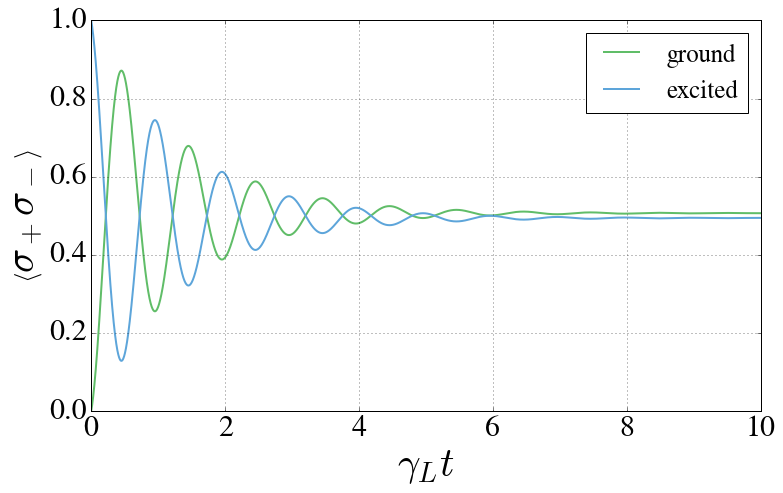

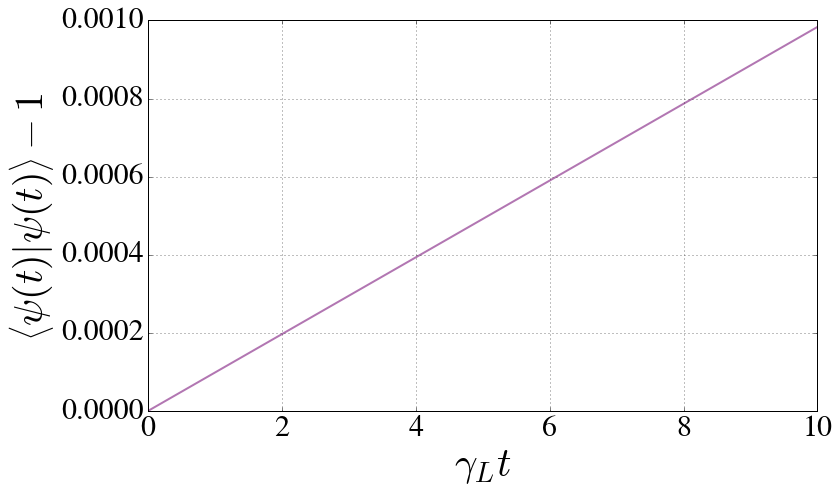

In [121]:
#index in the init list = timebin index: 0=16, ..., 15=1, 16=0, 17=S, 18=-1, 19=-2, 20=-3
start = time.time()
endt=1000000
init = [0]*endt
l=3
initTLS = np.array([0,1]) #starting at |e>
initenv = np.zeros(2)
initenv[0] = 1

gamma_L = 10.
Om_TLS  = 10.*np.pi#*gamma_L
Delta_T = 0.0
dt      = .000001
# Initial state of the system
init[endt-4] = initTLS

### This function basically implements the formula above without feedback ###
def U(tk,tS): #tk: time bin state at k, tS: state of S
    U_m      = sc.eye(tk.size,tk.size,1)*np.sqrt(np.arange(0,tk.size)) # decreasing the number of photons in the environment bin with 1
    #print(np.dot(U_m,tk))
    U_p      = sc.eye(tk.size,tk.size,-1)*np.sqrt(np.arange(1,tk.size+1)) # increasing the number of photons in the environment bin with 1
    #print(np.dot(U_p,tk))
    sm       = sc.eye(2,2,1) # sigma_-
    sp       = sc.eye(2,2,-1) # sigma_+
    
    ### Different terms in U ###
    
    #####Identity#####
    T_0      = np.tensordot(tk,tS,0) #identity operation
    
    #####Terms with \delta_{i_Tg}\Delta_{j_Te}#####
    U_tk_ig_je = - 1j*dt*Om_TLS*sc.eye(tk.size,tk.size) + \
                ( -1 + dt*gamma_L/6*np.arange(0,tk.size) + .5j*Delta_T*dt )*np.sqrt(dt*gamma_L)*U_m 
    T_ig_je = np.tensordot(np.dot(U_tk_ig_je,tk),np.dot(sp,tS),0)    
    
    #####Terms with \delta_{i_Te}\Delta_{j_Tg}#####
    U_tk_ie_jg = - 1j*dt*Om_TLS*sc.eye(tk.size,tk.size) + \
                ( 1- dt*gamma_L/6*np.arange(1,tk.size+1) - .5*Delta_T*dt )*np.sqrt(dt*gamma_L)*U_p 
    T_ie_jg = np.tensordot(np.dot(U_tk_ie_jg,tk),np.dot(sm,tS),0)    

    #####Terms with \delta_{i_Te}\Delta_{j_Te}#####
    U_tk_ie_je = -(.5*gamma_L*np.arange(1,tk.size+1) + 1j*Delta_T)*dt*sc.eye(tk.size,tk.size) -\
                1j*Om_TLS/2.*np.sqrt(gamma_L)*dt**1.5*(U_p - U_m)
    T_ie_je = np.tensordot(np.dot(U_tk_ie_je,tk), np.dot(np.array([[0,0],[0,1]]),tS),0)

    #####Terms with \delta_{i_Tg}\Delta_{j_Tg}#####
    U_tk_ig_jg = -(.5*gamma_L*np.arange(0,tk.size))*dt*sc.eye(tk.size,tk.size) +\
                1j*Om_TLS/2.*np.sqrt(gamma_L)*dt**1.5*(U_m - U_p)
    T_ig_jg = np.tensordot(np.dot(U_tk_ig_jg,tk), np.dot(np.array([[1,0],[0,0]]),tS),0)
    
    #nextstep = T_0 + T_sqdt_1 + T_sqdt_2 + T_dt_S_1 + T_dt_S_2 + T_dt_S_3 + T_dt_B_1 + T_dt_B_2    
    nextstep = T_0 + T_ig_je + T_ie_jg + T_ie_je + T_ig_jg
    return(nextstep)

print("initial excitation:",np.einsum("k,k",np.einsum("i,ik",initTLS,np.array([[0,0],[0,1]])),np.conjugate(initTLS)))
print("initial ground probability:",np.einsum("k,k",np.einsum("i,ik",initTLS,np.array([[1,0],[0,0]])),np.conjugate(initTLS)))
m=0
exc2 = np.zeros(endt-3,complex)
norm = np.zeros(endt-3,complex)
norm2 = np.zeros(endt-2,complex)
norm2[endt-3] = np.dot(init[endt-4],np.conjugate(init[endt-4]))
norm3 = np.zeros(endt-2,complex)
norm3[endt-3] = np.dot(init[endt-4],np.conjugate(init[endt-4]))
exc = np.zeros(endt-3,complex)

#IMPORTANT: One needs to be careful with the final indices that come out of the summation of einsum, better to define them.

for m in np.arange(endt-4,-1,-1):
#    print("before\n",init[m].shape)
#    print(init[m])
#    if m<endt-4:
#        print(init[m+1].shape)
#    print(m)

    ### Calculating the norm ###
    if m==endt-4:
        #print(init[m])
        nor11 = np.dot(init[m],np.conjugate(init[m]))
        #print("nor1",nor1)
    elif m==endt-5:
        nor21 = np.einsum("ik,jk->ij",init[m+1],np.conjugate(init[m+1]))
        nor11 = np.einsum("ij,ij",np.einsum("li,lj->ij",init[m],np.conjugate(init[m])),nor21)
    else:
        nor31 = np.einsum("mli,nlj->minj",init[m+1],np.conjugate(init[m+1]))
        nor21 = np.einsum("minj,ij->mn",nor31,nor21)
        #print("nor2=",nor2)
        #print(nor2.shape)
        nor11 = np.einsum("mn,mn",np.einsum("lm,ln->mn",init[m],np.conjugate(init[m])),nor21)
    norm[m] = nor11

    ### Determining the excitation level of the qubit ###
    if m==endt-4:
        exc[m]=np.einsum("k,k",np.einsum("i,ik",init[m],np.array([[1,0],[0,0]])),np.conjugate(init[m]))
        exc2[m]=np.einsum("k,k",np.einsum("i,ik",init[m],np.array([[0,0],[0,1]])),np.conjugate(init[m]))
    else:
#        exc2[m]=np.einsum("jk,kj",np.einsum("ij,ik->jk",init[m],np.array([[0,0],[0,1]])),np.conjugate(init[m]))
        exc2_pre=np.einsum("ik,kj->ij",np.einsum("li,lk->ik",init[m],np.array([[0,0],[0,1]])),np.conjugate(init[m]))
        exc2[m] = np.einsum("ij,ij",exc2_pre,nor21)
        exc_pre=np.einsum("ik,kj->ij",np.einsum("li,lk->ik",init[m],np.array([[1,0],[0,0]])),np.conjugate(init[m]))
        exc[m] = np.einsum("ij,ij",exc_pre,nor21)
#        exc[m]=np.einsum("jk,kj",np.einsum("ij,ik->jk",init[m],np.array([[1,0],[0,0]])),np.conjugate(init[m]))
    
    ### A time-step ###
    # We consider up to 4 excitations in the environmental timebin (first array)
    together = U(initenv,init[m]) #normalized
#    print("together shape\n",together.shape)
    if m==endt-4:
        tog_swap = np.einsum("ij->ji",together)
        tog_svd  = svd(tog_swap,full_matrices=False)
    else:
        tog_swap = np.einsum("ijk->jik",together)
        di = tog_swap[0,:,0].size
        dj = tog_swap[:,0,0].size
        dk = tog_swap[0,0,:].size
#        print("di=",di,", dk=",dk)
        tog_swap_conc = np.zeros((dj,di*dk),dtype=np.complex128)
        for i in range(0,tog_swap[0,:,0].size):
            for k in range(0,tog_swap[0,0,:].size):
                tog_swap_conc[:,i+di*k]=tog_swap[:,i,k]
        tog_svd_conc = svd(tog_swap_conc,full_matrices=False)
        tog_svd = [0.+0*1j]*3
        tog_svd[2] = np.zeros((dj,di,dk),dtype=np.complex128)
        for I in range(0,tog_swap_conc[:,0].size):
            tog_svd[2][:,I%di,int((I-(I%di))/di)]  = tog_svd_conc[0][:,I]
        tog_svd[1] = tog_svd_conc[1]
        tog_svd[0] = tog_svd_conc[0]

    ### Storing the different Matrices of the timebins and system (I'm not convinced that this is necessary) ###
    init[m] = tog_svd[2]
    init[m-1] = np.dot(tog_svd[0],np.diag(tog_svd[1]))
    ### Calculating the norm ###
#    if m==endt-4:
#        nor22 = np.einsum("ik,jk->ij",init[m],np.conjugate(init[m]))
#        nor12 = np.einsum("ij,ij",np.einsum("li,lj->ij",init[m-1],np.conjugate(init[m-1])),nor22)
#    else:
#        nor32 = np.einsum("mli,nlj->minj",init[m],np.conjugate(init[m]))
#        nor22 = np.einsum("minj,ij->mn",nor32,nor22)
#        nor12 = np.einsum("mn,mn",np.einsum("lm,ln->mn",init[m-1],np.conjugate(init[m-1])),nor22)
#    norm2[m] = nor12
    
#    for mi in range(endt-4,m-1,-1):
#        init[mi] = init[mi]/np.sqrt(norm2[mi])
#    init[m-1] = init[m-1]/np.sqrt(norm2[m])
    
    
#    print("after\n",init[m].shape)
#    print(init[m-1].shape)
#print(init[-1])

### Plotting to be happy ###
t=np.arange(0,endt-3)*dt*gamma_L
t2=np.arange(0,endt-2)*dt*gamma_L
end = time.time()
timeh = int((end-start)/3600)
timem = int((end-start)/60-timeh*60)
times = int((end-start)-timeh*3600-60*timem)
print("elapsed time: %02d:%02d:%02d" % (timeh,timem,times))


plt.figure(figsize = (12,7))
plt.plot(t,np.flip(np.real(exc),0),lw=2,label="ground",color=colors["green"])
plt.plot(t,np.flip(np.real(exc2),0),lw=2,label="excited",color=colors["blue"])
#plt.plot(t,np.exp(-gamma_L*t),ls="--",lw=4,color=colors["orange"],label="$\exp{(-\gamma_Lt)}$")
#plt.xlim(0,8)
#plt.ylim(-0.01,1.01)
plt.xlabel("$\gamma_Lt$",fontsize=40)
plt.ylabel("$\left<\sigma_+\sigma_-\\right>$",fontsize=40)
plt.legend(fontsize=25,loc="upper right")
plt.grid(True)
plt.figure(2,figsize = (12,7))
plt.plot(t,np.flip(np.real(norm-1),0),lw=2,label="norm",color=colors["purple"])
plt.grid(True)
plt.ylabel("$\left<\psi(t)|\psi(t)\\right>-1$",fontsize=40)
plt.xlabel("$\gamma_Lt$",fontsize=40)
plt.show()


In [111]:
delt = np.zeros(6)
spin = np.zeros(6)

In [122]:
delt[3]=dt
spin[3]=exc[0]

/home/nnem614/Documents/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


[1.34926875 0.55821592 0.51096822 0.50646852 0.         0.        ]


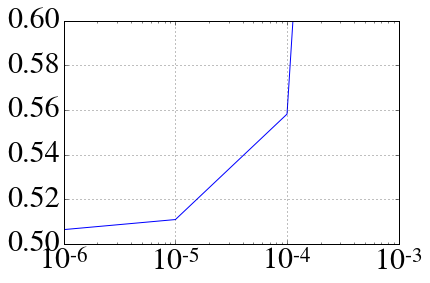

In [123]:
print(spin)
plt.semilogx(delt,spin)
plt.ylim(0.5,0.6)
plt.grid(True)

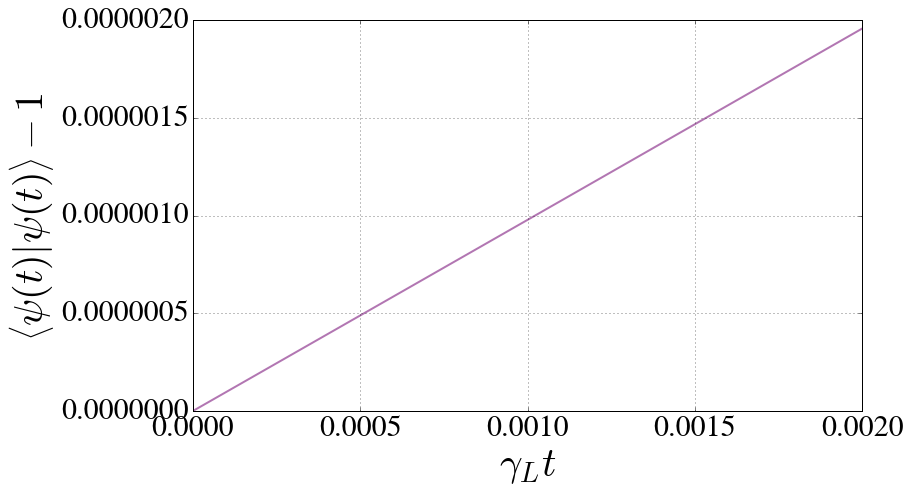

In [72]:
plt.figure(2,figsize = (12,7))
plt.plot(t,np.flip(np.real(norm-1),0),lw=2,label="norm",color=colors["purple"])
plt.grid(True)
plt.ylabel("$\left<\psi(t)|\psi(t)\\right>-1$",fontsize=40)
plt.xlabel("$\gamma_Lt$",fontsize=40)
plt.xlim(0,.002)
plt.ylim(0,.000002)
plt.show()